# Basic Formulas 

In [218]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [219]:
def compute_rho(lambda_i, N, m, mu_i):
    return lambda_i / (N * m * mu_i)

In [220]:
def compute_pi_0(lambda_i, N, m, mu_i, K):
    rho_i = compute_rho(lambda_i, N, m, mu_i)
    res = 1

    if rho_i != 1:
        res += sum(((m*rho_i) ** k) / sp.factorial(k) for k in range(1, m))
        res += ((1 - (rho_i**(K-m+1)))*pow(m*rho_i, m)) / \
            (sp.factorial(m)*(1-rho_i))

    else:
        res += sum((m**k)/sp.factorial(k) for k in range(1, m))
        res += (m**m) * (K-m+1)/sp.factorial(m)

    return 1/res

In [222]:
def compute_pi_n(lambda_i, N, m, mu_i, K, n):
    pi_0 = compute_pi_0(lambda_i, N, m, mu_i, K)
    rho_i = compute_rho(lambda_i, N, m, mu_i)

    if n < m:
        res = (m*rho_i) ** n / sp.factorial(n)
    else:
        res = (rho_i**n) * (m**m) / sp.factorial(m)

    return res*pi_0

In [223]:
def compute_lambda_dash(lambda_i, N, m, mu_i, K):
    return lambda_i * (1 - compute_pi_n(lambda_i, N, m, mu_i, K, K))/N

In [224]:
def compute_cpu_usage(lambda_i, N, m, mu_i, K):
    u = sum(j*compute_pi_n(lambda_i, N, m, mu_i, K, j) for j in range(0, m))
    u += sum(m*compute_pi_n(lambda_i, N, m, mu_i, K, j)
             for j in range(m+1, K+1))

    u /= m
    return u

In [225]:
def compute_rejection_probablity(lambda_i, N, m, mu_i, K):
    return compute_pi_n(lambda_i, N, m, mu_i, K, K)

In [226]:
def compute_tasks_in_queue(lambda_i, N, m, mu_i):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return rho**2 / (1 - rho)


def compute_mean_waiting_time(lambda_i, N, m, mu_i, mu):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return rho / (mu*(1-rho))


def compute_mean_waiting_tasks(lambda_i, N, m, mu_i, K):
    res = sum((j - m)*compute_pi_n(lambda_i, N, m, mu_i, K, j)
              for j in range(m+1, K+1))

    return res


def compute_mean_waiting_tasks(lambda_i, N, m, mu_i, K):
    Q_dash = compute_mean_waiting_tasks(lambda_i, N, m, mu_i, K)
    lambda_dash = compute_lambda_dash(lambda_i, N, m, mu_i, K)
    return Q_dash/lambda_dash


def compute_average_number_of_tasks_per_queue(lambda_i, N, m, mu_i):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return rho / (1-rho)


def compute_average_queue_response_time(lambda_i, N, m, mu_i, mu):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return 1 / (mu*(1-rho))


def compute_average_number_of_tasks_per_pm(lambda_i, N, m, mu_i, K):
    return sum(j*compute_pi_n(lambda_i, N, m, mu_i, K, j) for j in range(0, K+1))


def compute_average_response_time(lambda_i, N, m, mu_i, K):
    N_dash = compute_average_number_of_tasks_per_pm(lambda_i, N, m, mu_i, K)
    lambda_dash = compute_lambda_dash(lambda_i, N, m, mu_i, K)
    return N_dash/lambda_dash

# JMT Model

In [227]:
import pyJMT as jmt
import pandas as pd

In [228]:
def create_model(name, mu, arrival_rate=20, N=10, m=15, K=100):
    model = jmt.Network("M/M/c/K Task Classification System")

    source = jmt.Source(model, "From Task Classifier")
    queue = jmt.Router(model, name + "_Queue")
    sink = jmt.Sink(model, "Task Completed")

    PMS = [jmt.Queue(model, f"{name}_PM_{i}",
                     jmt.SchedStrategy.FCFS, dropRule=jmt.DropStrategy.DROP) for i in range(N)]

    tasks = jmt.OpenClass(model, "Tasks")
    source.setArrival(tasks, jmt.Exp(arrival_rate))
    source.setRouting(tasks, jmt.RoutingStrategy.PROB)
    source.setProbRouting(tasks, queue, 1)
    # queue.setService(tasks, jmt.Exp(25000))
    queue.setRouting(tasks, jmt.RoutingStrategy.RROBIN)

    for pm in PMS:
        pm.setService(tasks, jmt.Exp(mu*m))
        pm.setNumberOfServers(m)
        pm.setCapacity(K)

        model.addLinks([
            (queue, pm),
            (pm, sink)
        ])
        model.addMetric(tasks, pm, jmt.Metrics.UTILIZATION)

    model.addMetric(tasks, model, jmt.Metrics.RESPONSE_TIME)
    model.addMetric(tasks, model, jmt.Metrics.THROUGHPUT)

    model.addLink(source, queue)
    model.defaultMetrics = False

    print(f"Created model {name}")
    return model

In [229]:
def get_avg_cpu_metrics(result,m):
    df = pd.DataFrame([
        {
            "node": node,
            "meanValue": float(data["meanValue"]),
            "measureType": data["measureType"],

        }
        for node, datas in result.items()
        for data in datas["Tasks"]
    ])

    utilization = df[df['measureType'] == "Utilization"]

    avg_util = utilization["meanValue"].sum()/len(utilization)

    return min(avg_util*m*100, 100)

# 1. CPU Usage vs Arrival Rate

In [230]:
# no of physical machine, no of VM in physical machine, maximum queue capacity per VM
N, M, K = 10, 15, 100
service_rate = (45, 90, 150)

lambda_values = np.linspace(0, 2*10**4, 100).astype(int)
lambda_values_jmt = np.linspace(20, 2*10**4, 10).astype(int)
cpu_usage_values = [[], [], []]
cpu_usage_values_jmt = [[], [], []]

In [231]:
# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        cpu_usage = compute_cpu_usage(lambda_i, N, M, mu_i, K)*100
        cpu_usage_values[i].append(cpu_usage)

In [232]:
for lambda_i in lambda_values_jmt:
    for i, mu_i in enumerate(service_rate):
        model = create_model(f"{mu_i}_{lambda_i}", mu_i, lambda_i)
        result = model.getResults()
        cpu_usage_values_jmt[i].append(get_avg_cpu_metrics(result,M))

Created model 45_20
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\output_files\tmpa3qsjkge.jsimg"  -maxtime 600 
Created model 90_20
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\output_files\tmper2wx3en.jsimg"  -maxtime 600 
Created model 150_20
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\output_files\tmpdb4ntavp.jsimg"  -maxtime 600 
Created model 45_2240
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\www

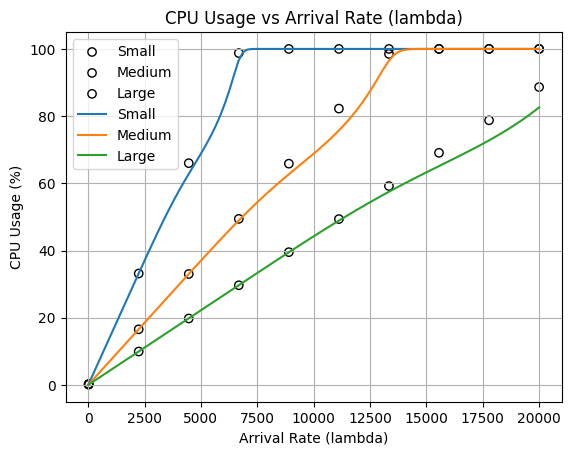

In [233]:
# CPU Usage vs Arrival Rate (lambda)
plt.scatter(lambda_values_jmt, cpu_usage_values_jmt[0], label="Small",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, cpu_usage_values_jmt[1], label="Medium",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, cpu_usage_values_jmt[2], label="Large",
            marker='o', edgecolors='black', facecolors='none')
plt.plot(lambda_values, cpu_usage_values[0], label="Small")
plt.plot(lambda_values, cpu_usage_values[1], label="Medium")
plt.plot(lambda_values, cpu_usage_values[2], label="Large")
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 2. CPU usage across varying VM counts and task arrival rates.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
# Ranges for the variables
lambda_values = np.linspace(1, 2000, 1000).astype(int)  # Adjusted range for lambda
m_values = np.linspace(1, 40, 20).astype(int)  # Adjusted range for VMs

# Create the grid
X, Y = np.meshgrid(lambda_values,m_values)

In [ ]:
# Calculate CPU usage for each combination
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        lambda_i = int(X[i, j])
        m_3d = int(Y[i, j])
        cpu_usage = compute_cpu_usage(lambda_i, 1, m_3d, service_rate[1], K) * 100
        Z[i, j] = cpu_usage

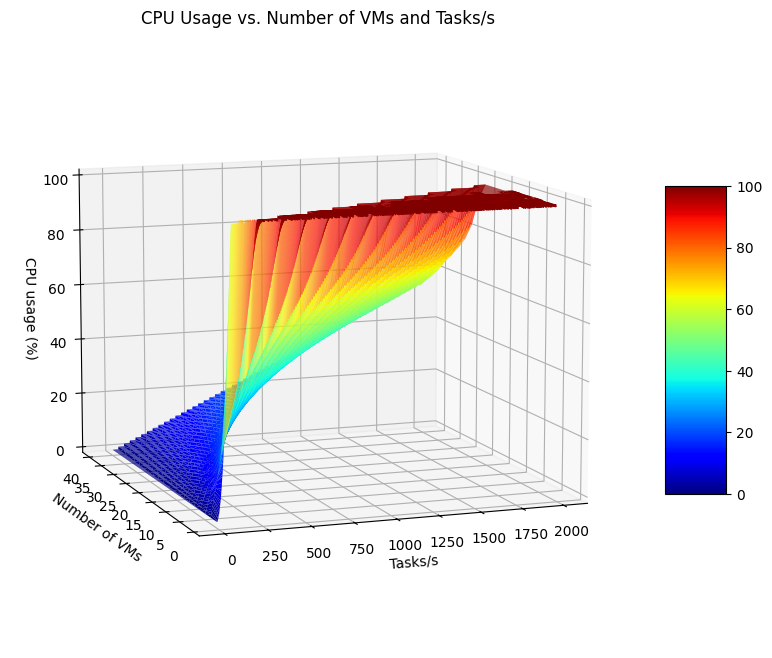

In [ ]:
# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the 'jet' color map and increase resolution
surf = ax.plot_surface(X, Y, Z, cmap='jet', rstride=1, cstride=1, edgecolor='none')

# Set labels and title
ax.set_xlabel('Tasks/s')
ax.set_ylabel('Number of VMs')
ax.set_zlabel('CPU usage (%)')
ax.set_title('CPU Usage vs. Number of VMs and Tasks/s')

# Adjust view angle to match the first image
ax.view_init(elev=10, azim=-110,roll=0)

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# 3. Rejection Probablity

In [234]:
lambda_values = np.linspace(0, 2*10**4, 50).astype(int)
rejection_probablity = [[], [], []]
lambda_values_jmt = np.linspace(20, 2*10**4, 10)
rejection_probablity_jmt = [[], [], []]
lambda_values_jmt

array([   20.,  2240.,  4460.,  6680.,  8900., 11120., 13340., 15560.,
       17780., 20000.])

In [235]:
# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        # keep N as 1 as we care about only vms
        rejection = compute_rejection_probablity(lambda_i, 1, M, mu_i, K)
        rejection_probablity[i].append(rejection)

In [236]:

rejection_probablity_jmt[0] = [19.9601, 677.8005, 671.4770, 679.7308,
                               674.8608, 676.2559, 670.9336, 677.3154, 676.9195, 675.0773]
rejection_probablity_jmt[1] = [20.4216, 1355.0521, 1351.4703, 1338.6376,
                               1344.5802, 1351.7060, 1342.0676, 1345.1148, 1344.5109, 1356.3670]
rejection_probablity_jmt[2] = [20.4133, 2234.0874, 2244.9299, 2266.6905,
                               2234.0432, 2225.6654, 2251.0883, 2252.5419, 2257.5513, 2247.9816]
for i,lambda_i in enumerate(lambda_values_jmt):
    for j, mu_i in enumerate(service_rate):
        # keep N as 1 as we care about only vms
        rejection_probablity_jmt[j][i] = 1 - (rejection_probablity_jmt[j][i]/lambda_i)
        # model = create_model(f"{mu_i}_{lambda_i}", mu_i, lambda_i, 1, M, K)
        # results = model.getResults()['']["Tasks"]
        # for result in results:
        #     if result["measureType"] == "System Throughput":
        #         print(result['meanValue'])
        #         throughput_ratio = min(float(result['meanValue'])/lambda_i, 1)
        #         rejection_probablity_jmt[j].append(1-throughput_ratio)


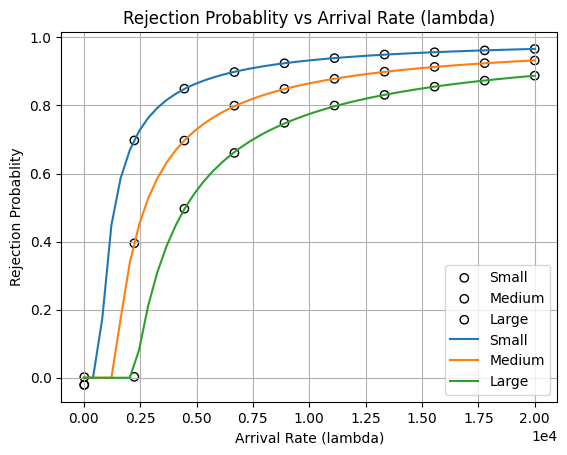

In [237]:
# Plot the graph
plt.scatter(lambda_values_jmt, rejection_probablity_jmt[0], label="Small",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, rejection_probablity_jmt[1], label="Medium",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, rejection_probablity_jmt[2], label="Large",
            marker='o', edgecolors='black', facecolors='none')
plt.plot(lambda_values, rejection_probablity[0], label="Small")
plt.plot(lambda_values, rejection_probablity[1], label="Medium")
plt.plot(lambda_values, rejection_probablity[2], label="Large")
plt.xlabel("Arrival Rate (lambda)")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel("Rejection Probablity")
plt.title("Rejection Probablity vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 4. Task rejection probability across varying VM counts and task arrival rates.

# 5. Response Time

In [238]:
lambda_values = np.linspace(0, 2*10**4, 100)
response_time = [[], [], []]
lambda_values_jmt = np.linspace(20, 2*10**4, 10)
response_time_jmt = [[], [], []]
lambda_values_jmt

array([   20.,  2240.,  4460.,  6680.,  8900., 11120., 13340., 15560.,
       17780., 20000.])

In [239]:
# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        res = compute_average_response_time(lambda_i, N, M, mu_i, K)
        response_time[i].append(res)

In [240]:
# Calculate CPU usage for each lambda
# for lambda_i in lambda_values_jmt:
#     for i, mu_i in enumerate(service_rate):
#         model = create_model(f"{mu_i}_{lambda_i}", mu_i, lambda_i)
#         results = model.getResults()['']["Tasks"]
#         for result in results:
#             if result["measureType"] == "System Response Time":
#                 print(result['meanValue'])
#                 response_time_jmt[i].append(float(result['meanValue']))
response_time_jmt[0] = [1.49E-3, 1.61E-3, 2.67E-3, 0.0607,
                        0.1457, 0.1468, 0.1461, 0.1491, 0.1475, 0.1478]
response_time_jmt[1] = [7.43E-4, 7.48E-4, 8.09E-4, 9.69E-4,
                        1.33E-3, 2.42E-3, 0.0254, 0.0711, 0.0723, 0.0732]
response_time_jmt[2] = [4.46E-4, 4.46E-4, 4.51E-4, 4.73E-4,
                        5.11E-4, 5.89E-4, 6.88E-4, 8.76E-4 , 1.26E-3, 2.24E-3]

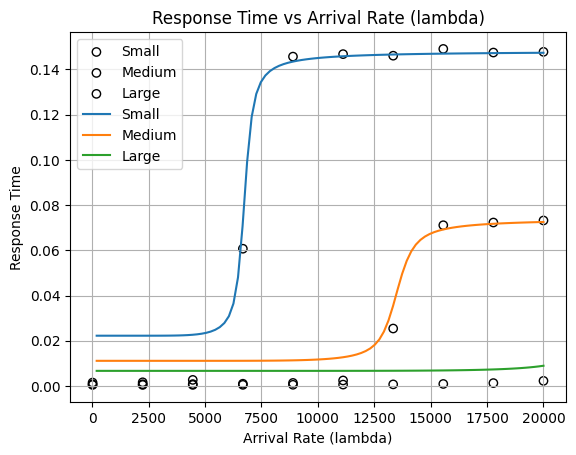

In [241]:
# Plot the graph
plt.scatter(lambda_values_jmt, response_time_jmt[0], label="Small",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, response_time_jmt[1], label="Medium",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, response_time_jmt[2], label="Large",
            marker='o', edgecolors='black', facecolors='none')
plt.plot(lambda_values, response_time[0], label="Small")
plt.plot(lambda_values, response_time[1], label="Medium")
plt.plot(lambda_values, response_time[2], label="Large")
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("Response Time")
plt.title("Response Time vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 6. Response time across varying VM counts and task arrival rates.

# 7. Energy Consumption vs Arrival Rate

In [ ]:
# energy consumption per machine
E_base = 100

# energy consumption per vm
E_vm = [20, 35, 50]

# energy consumption for m vm's
E_m_vm = [M*x for x in E_vm]

In [ ]:
lambda_values = np.linspace(0, 500, 11).astype(int)
enegry_consumption = [[], [], []]

# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        cpu_usage = compute_cpu_usage(lambda_i, N, M, mu_i, K)
        # for n phyical machine 
        energy_usage = E_base*N + E_m_vm[i] * cpu_usage
        enegry_consumption[i].append(energy_usage)

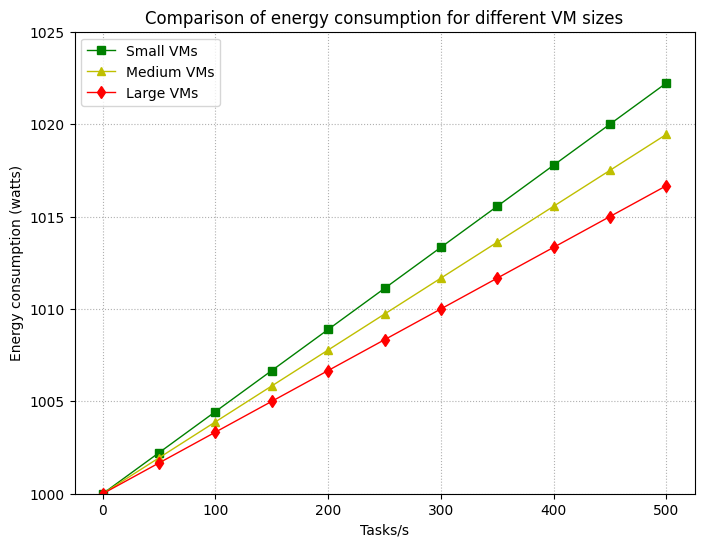

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, enegry_consumption[0],
         'g-s', label='Small VMs', linewidth=1)
plt.plot(lambda_values, enegry_consumption[1],
         'y-^', label='Medium VMs', linewidth=1)
plt.plot(lambda_values, enegry_consumption[2],
         'r-d', label='Large VMs', linewidth=1)

plt.xlabel('Tasks/s')
plt.ylabel('Energy consumption (watts)')
plt.yticks(np.arange(1000, 1026, 5))
plt.ylim(1000, 1025)
plt.legend()
plt.grid(True, linestyle=':')
plt.title('Comparison of energy consumption for different VM sizes')
plt.show()